In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter
import os
#import cv2
import random
import tensorflow as tf

from tensorflow import keras

In [2]:
from imutils import paths
import face_recognition
import pickle
import cv2
import os

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6599144680116221349
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4841275392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11541301973317309629
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [4]:
imagePaths =r'D:\TeachMeSkills\DZ\dz27\wiki_crop\new'

In [5]:
from tqdm import tqdm

In [6]:
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for filenames in os.listdir(imagePaths):
    end = filenames[-8:-4]
    start = filenames.split('_')[1].split('-')[0]
    age = int(end)-int(start)
    link2 = os.path.join(r'D:\TeachMeSkills\DZ\dz27\wiki_crop\new', filenames)
    df.loc[len(df.index )] = [link2,age]
            

In [7]:
df

,link,age
0,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1000021...,28
1,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\100012_...,60
2,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1000270...,52
3,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1000354...,34
4,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1000429...,42
...,...,...
30616,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9996817...,24
30617,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9996824...,25
30618,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9996949...,26
30619,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9998109...,41


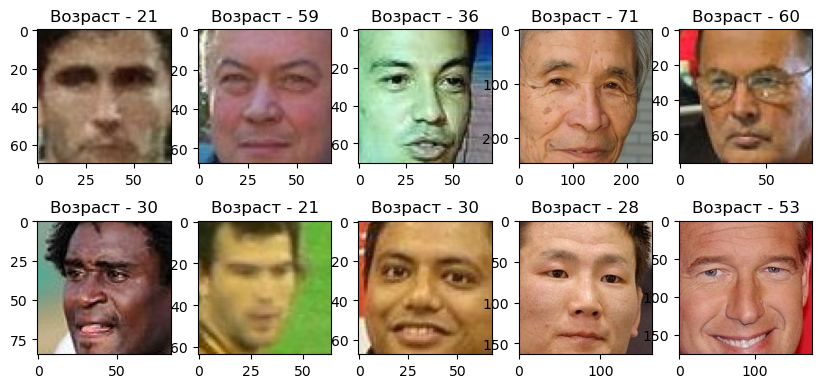

In [8]:
idx = np.random.randint (0,len(df),10)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = df.iloc[idx[1]]
        image = plt.imread(link[0])
        title = 'Возраст - ' + str(link[1])
        plt.title (title)
        plt.imshow(image, cmap='gray')

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,GlobalMaxPool2D, Conv2D, MaxPooling2D,Activation, Flatten, CategoryEncoding,Dropout, BatchNormalization, AveragePooling2D, MultiHeadAttention
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=34)

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [12]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

Found 17148 validated image filenames.
Found 7348 validated image filenames.
Found 6125 validated image filenames.


In [13]:
from tensorflow.keras.applications import resnet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input

In [14]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(GlobalMaxPool2D())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer = Adam(),loss="mse", metrics=["mae"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
checkpoint_cb_conv = ModelCheckpoint("MyModel.h5",
                                         monitor = 'val_mae',
                                         save_best_only=True) 
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [18]:
history_model = model.fit(train_generator, validation_data=valid_generator,callbacks=[checkpoint_cb_conv,lr_scheduler], epochs=20)

Epoch 1/20
536/536 [==============================] - 547s 1s/step - loss: 575.6314 - mae: 14.1111 - val_loss: 268.0704 - val_mae: 13.1477 - lr: 5.0000e-04
Epoch 2/20
536/536 [==============================] - 25s 47ms/step - loss: 531.2825 - mae: 13.3199 - val_loss: 234.1544 - val_mae: 11.9478 - lr: 5.0000e-04
Epoch 3/20
536/536 [==============================] - 20s 37ms/step - loss: 479.6532 - mae: 11.8128 - val_loss: 222.2222 - val_mae: 11.5724 - lr: 5.0000e-04
Epoch 4/20
536/536 [==============================] - 20s 37ms/step - loss: 452.6426 - mae: 11.1430 - val_loss: 215.1312 - val_mae: 11.9223 - lr: 5.0000e-04
Epoch 5/20
536/536 [==============================] - 21s 39ms/step - loss: 458.0172 - mae: 11.3936 - val_loss: 184.1660 - val_mae: 10.5687 - lr: 5.0000e-04
Epoch 6/20
536/536 [==============================] - 20s 38ms/step - loss: 435.2534 - mae: 10.7584 - val_loss: 188.6045 - val_mae: 10.6749 - lr: 5.0000e-04
Epoch 7/20
536/536 [==============================] - 20s 3

In [19]:
model.evaluate(test_generator)

192/192 [==============================] - 156s 814ms/step - loss: 163.5558 - mae: 9.7299


[163.55580139160156, 9.729911804199219]

In [21]:
NUM_IMAGES = 1000
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected = []
predicted = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[0])
    img_resized = cv2.resize (image, (64,64))/255 #,
    img_reshaped  = img_resized.reshape (1,64,64,3)
    predict = model.predict(img_reshaped, verbose=0)[0][0];
    
    expected.append (link[1])
    predicted.append (predict)

Prediction: 1000it [01:07, 14.72it/s]


In [22]:
mean_absolute_error(expected,predicted)

9.471882036209106

In [23]:
del model
import gc
gc.collect()

57476

In [24]:
import onnx, tf2onnx
import tensorrt as trt

In [25]:
model = load_model("MyModel.h5")

In [26]:
spec = (tf.TensorSpec((None, 64, 64, 3), tf.float32, name="input"),)

onnx_MyModel, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
onnx.save(onnx_MyModel, r'D:\TeachMeSkills\DZ\dz31\onnx_Model.onnx')

!python onnx_Model.onnx --dynamic_axes True --onnx_Model onnx_output_explicit.onnx --batch_size {1} --tensorrt_engine_path FP32_explicit.engine --engine_precision FP32 

In [27]:
onnx_model = onnx.load_model('onnx_Model.onnx')

In [28]:
inputs = onnx_model.graph.input
for input in inputs:
    dim = input.type.tensor_type.shape.dim[0]
    dim.dim_value = 1
    
model_name = "onnx_Model.onnx"
onnx.save_model(onnx_model, model_name)

fp32

In [29]:
!trtexec --onnx=onnx_Model.onnx --saveEngine=onnx_Model.trt  --explicitBatch

&&&& RUNNING TensorRT.trtexec [TensorRT v8503] # trtexec --onnx=onnx_Model.onnx --saveEngine=onnx_Model.trt --explicitBatch
[04/16/2023-19:09:57] [I] === Model Options ===
[04/16/2023-19:09:57] [I] Format: ONNX
[04/16/2023-19:09:57] [I] Model: onnx_Model.onnx
[04/16/2023-19:09:57] [I] Output:
[04/16/2023-19:09:57] [I] === Build Options ===
[04/16/2023-19:09:57] [I] Max batch: explicit batch
[04/16/2023-19:09:57] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[04/16/2023-19:09:57] [I] minTiming: 1
[04/16/2023-19:09:57] [I] avgTiming: 8
[04/16/2023-19:09:57] [I] Precision: FP32
[04/16/2023-19:09:57] [I] LayerPrecisions: 
[04/16/2023-19:09:57] [I] Calibration: 
[04/16/2023-19:09:57] [I] Refit: Disabled
[04/16/2023-19:09:57] [I] Sparsity: Disabled
[04/16/2023-19:09:57] [I] Safe mode: Disabled
[04/16/2023-19:09:57] [I] DirectIO mode: Disabled
[04/16/2023-19:09:57] [I] Restricted mode: Disabled
[04/16/2023-19:09:57] [I] Build only: Disab

[04/16/2023-19:09:57] [W] --explicitBatch flag has been deprecated and has no effect!
[04/16/2023-19:09:57] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[04/16/2023-19:10:01] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars
[04/16/2023-19:10:01] [W] [TRT] onnx2trt_utils.cpp:377: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[04/16/2023-19:10:03] [W] [TRT] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.1.0
[04/16/2023-19:10:11] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars
[04/16/2023-19:10:1

fp16

In [44]:
!trtexec --onnx=onnx_Model.onnx --saveEngine=onnx_Modelfp16.trt  --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16

&&&& RUNNING TensorRT.trtexec [TensorRT v8503] # trtexec --onnx=onnx_Model.onnx --saveEngine=onnx_Modelfp16.trt --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16
[04/16/2023-20:11:37] [I] === Model Options ===
[04/16/2023-20:11:37] [I] Format: ONNX
[04/16/2023-20:11:37] [I] Model: onnx_Model.onnx
[04/16/2023-20:11:37] [I] Output:
[04/16/2023-20:11:37] [I] === Build Options ===
[04/16/2023-20:11:37] [I] Max batch: explicit batch
[04/16/2023-20:11:37] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[04/16/2023-20:11:37] [I] minTiming: 1
[04/16/2023-20:11:37] [I] avgTiming: 8
[04/16/2023-20:11:37] [I] Precision: FP32+FP16
[04/16/2023-20:11:37] [I] LayerPrecisions: 
[04/16/2023-20:11:37] [I] Calibration: 
[04/16/2023-20:11:37] [I] Refit: Disabled
[04/16/2023-20:11:37] [I] Sparsity: Disabled
[04/16/2023-20:11:37] [I] Safe mode: Disabled
[04/16/2023-20:11:37] [I] DirectIO mode: Disabled
[04/16/2023-20:11:37] [I] 

[04/16/2023-20:11:37] [W] --explicitBatch flag has been deprecated and has no effect!
[04/16/2023-20:11:37] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[04/16/2023-20:11:42] [W] [TRT] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars
[04/16/2023-20:11:42] [W] [TRT] onnx2trt_utils.cpp:377: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[04/16/2023-20:11:43] [W] [TRT] TensorRT was linked against cuDNN 8.6.0 but loaded cuDNN 8.1.0
[04/16/2023-20:11:54] [W] [TRT] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[04/16/2023-20:11:54] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regul